# SQLite

In [1]:
from ipywidgets import widgets
from IPython.display import display
import time
import json
import os
import pandas as pd
import glob
from sqlalchemy import create_engine
import string
import re
import contractions
from emoji import UNICODE_EMOJI
string.punctuation
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

def remove_Atsign(text):
    """Remove at sign from the input Text"""
    return re.sub(r"@\S+", "", text)

def remove_URL(text):
    """Remove URL from the input Text"""
    return re.sub(r"http\S+", "", text)

def remove_Contraction(text):
    """Remove Contraction from the input Text"""
    try:
        text = contractions.fix(text)
    except:
        pass
    return(text)

def remove_Emoji(text):
    """Remove Emoji"""
    return ''.join(c for c in text if c not in UNICODE_EMOJI['en'])

def remove_GUID(text):
    """Remove URL from the input Text"""
    return re.sub(r"[0-9a-f]{8}-[0-9a-f]{4}-[1-5][0-9a-f]{3}-[89ab][0-9a-f]{3}-[0-9a-f]{12}", "", text)

def remove_Numbers(text):
    """Remove Numbers from the input Text"""
    remove_digits = str.maketrans('', '', string.digits)
    return(text.translate(remove_digits))

def remove_Punctuation(text):
    """Remove Punctuation from the input Text"""
    """!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~"""
    text_punctuated = "".join([char for char in text if char not in string.punctuation])
    return text_punctuated

def user_id(user):
    try:
        return(user['id'])
    except:
        pass

def user_location(user):
    try:
        return(user['location'])
    except:
        pass

def extended_tweet(extended):
    try:
        return(extended['full_text'])
    except:
        pass

def user_description(user):
    try:
        if (user['description']):
            return(' ' + user['description'])
        else:
            return(' 0')
    except:
        pass

def tokenize_data(text):
    """Tokenizing input text"""
    tokens = re.split('\W+', text.lower())
    return tokens

def remove_Stopwords(text):
    """Removing Stops words"""
    stopwords = nltk.corpus.stopwords.words('english')
    #Adding additional words to the list of stop words to remove them
    #addition_StopWords = []
    #stopwords.extend(addition_StopWords)
    text_stopwords = [word for word in text if word not in stopwords]
    return(text_stopwords)

def lemmatizing(text):
    """Lemmatizing the input text using WordNet and NLTK package"""
    NLTK_WNL = nltk.WordNetLemmatizer()
    text_Lem = [NLTK_WNL.lemmatize(word) for word in text]
    return(text_Lem)

def tweet_cleaning(text):
    """Cleaning and Lemmatizing Tweets"""
    text = remove_URL(text)
    text = remove_Atsign(text)
    text = remove_Emoji(text)
    text = remove_GUID(text)
    text = remove_Numbers(text)
    text = remove_Contraction(text)
    text = remove_Punctuation(text)
    text = tokenize_data(text)
    text = remove_Stopwords(text)
    text = lemmatizing(text)
    return(text)

def find_WrCapital(text):
    valid_Capital = ['INFP ', 'INFJ ', 'INTP ', 'INTJ ', 'ENTP ', 'ENFP ', 'ISTP ', 'ISFP ', 'ENTJ ', 'ISTJ ', 'ENFJ ', 'ISFJ ', 'ESTP ', 'ESFP ', 'ESFJ ', 'ESTJ ', 'MBTI ']
    match= re.findall('[A-Z]{3,15}\s{1}', text)
    match = [item for item in match if item not in valid_Capital]
    return(len(match))

def count_Words_in_quotes(text):
    x = re.findall(r"(?P<quote>['\"])(?P<string>.*?)(?<!\\)(?P=quote)", text)
    return len(x)

def count_UniqueWords(text):
    text = re.sub(r'[^\w\s]','',text) #Remove Punctuations
    return len(set(text.split()))

def sentiment_Score(text):
    sia = SentimentIntensityAnalyzer()
    return(sia.polarity_scores(text).get('compound'))

    
datastore_Path = "D:/F-drive-31578/Twitter-2020-08/all"
tweet_Cols = ['u_id', 'tweet', 'No_Words-Capital', 'No_WordsInQuotes', 'Avg_WordLength', 'UniqueWrd_vs_NoWrd', 'Sentiment_Score', 'retweeted', 'geo', 'coordinates', 'place']
#tweet_Cols = ['u_id', 'u_location', 'u_description', 'id', 'text', 'retweeted', 'geo', 'coordinates', 'place', 'extended_tweet']

df_List = [] #An empty list to keep DataFrames
json_Filelist = glob.glob(os.path.join(datastore_Path, '*.json'))


prog = widgets.IntProgress(continuous_update=False, min=0, max=len(json_Filelist), 
                            description=  '0/' + str(len(json_Filelist)) + '  ', orientation='horizontal',
                            style={'bar_style': 'success'})# instantiate the bar
display(prog)# display the bar

engine = create_engine('sqlite:///C:\Tweets\\Tweets_clean_08.db', echo = False)
sqlite_connection = engine.connect()

for file in json_Filelist:
    try:
        df_Temp = pd.read_json(file, lines=True)
    
        df_Temp = df_Temp[df_Temp['lang'] == 'en'] #Only English Tweets
        df_Temp = df_Temp[df_Temp['geo'].notnull()] #Remove tweets wihtout geo information
        df_Temp['u_id'] = df_Temp['user'].apply(lambda x: user_id(x)) #Extract User ID
        df_Temp = df_Temp[df_Temp['extended_tweet'].notnull()]  #Remove short tweets by checking for extended_tweet
        df_Temp['extended_tweet'] = df_Temp['extended_tweet'].apply(lambda x: extended_tweet(x)) #Extract extended tweets
        #df_Temp['tweet'] = df_Temp['extended_tweet'] + df_Temp['u_description']
        df_Temp['tweet'] = df_Temp['extended_tweet']

        df_Temp['No_Words-Capital'] = df_Temp['tweet'].apply(lambda X: find_WrCapital(remove_URL(X)))
        df_Temp['No_WordsInQuotes'] = df_Temp['tweet'].apply(lambda X: count_Words_in_quotes(remove_URL(X)))

        df_Temp['No_Characters'] = df_Temp['tweet'].apply(lambda X: len(remove_URL(X)) - remove_URL(X).count(' '))
        df_Temp['No_Words'] = df_Temp['tweet'].apply(lambda X: len(remove_URL(X).split()))
        df_Temp['Avg_WordLength'] = df_Temp['No_Characters']/df_Temp['No_Words']
        df_Temp['No_UniqueWords'] = df_Temp['tweet'].apply(lambda X: count_UniqueWords(remove_URL(X)))
        df_Temp['UniqueWrd_vs_NoWrd'] = df_Temp['No_UniqueWords']/df_Temp['No_Words']
        df_Temp['Sentiment_Score'] = df_Temp['tweet'].apply(lambda X: sentiment_Score(remove_URL(X)))
        df_Temp['tweet'] = df_Temp['tweet'].apply(lambda x: tweet_cleaning(x))

        
        df_Temp[tweet_Cols].astype(str).to_sql("Tweets", sqlite_connection, if_exists="append")
        
        #os.remove(file)#remove json after importing to DB

        prog.value += 1 # signal to increment the progress bar
        prog.description =  str(prog.value) + '/' + str(len(json_Filelist)) + '  '
    except:
        pass
 
sqlite_connection.close()

IntProgress(value=0, description='0/43692  ', max=43692)

# Making the model model
Here Naive Bayse was used, to change it to GBoosting, uncomment fields, model and if statement in the code.

In [94]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
from joblib import dump, load
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import pickle


def lemmatizing(text):
    """Lemmatizing the input text using WordNet and NLTK package"""
    NLTK_WNL = nltk.WordNetLemmatizer()
    text_Lem = [NLTK_WNL.lemmatize(word) for word in text]
    return(text_Lem)

classes = ['IE' , 'NS', 'FT', 'PJ']
fields = ['No_Words-Capital', 'No_WordsInQuotes', 'Avg_WordLength', 'UniqueWrd_vs_NoWrd', 'Sentiment_Score']

mbti_Dataset = pd.read_pickle('mbti_FE.pkl')

#Removing '' from the the dataset
condition = False
while condition == False:
    condition = True
    for i in mbti_Dataset.Posts_Lemmatized:
        if '' in i:
            i.remove('')
    for i in mbti_Dataset.Posts_Lemmatized:
        if '' in i:
            condition = False

mbti_Dataset['Avg_WordLength'] = mbti_Dataset['Avg_WordLength'].apply(lambda x: round(x,2))#Round Avg_WordLength
mbti_Dataset['UniqueWrd_vs_NoWrd'] = mbti_Dataset['UniqueWrd_vs_NoWrd'].apply(lambda x: round(x,2))#UniqueWrd_vs_NoWrd
mbti_Dataset['Sentiment_Score'] = mbti_Dataset['Sentiment_Score'].apply(lambda x: round(x,2))#UniqueWrd_vs_NoWrd


tfidf = TfidfVectorizer(analyzer=lemmatizing)
tfidf_fit = tfidf.fit(mbti_Dataset['Posts_Lemmatized'])
pickle.dump(tfidf_fit, open("tfidf_all_fit.pkl", "wb"))

tfidf_all = tfidf_fit.transform(mbti_Dataset['Posts_Lemmatized'])

x_tfidf = pd.concat([mbti_Dataset[fields].reset_index(drop=True),
                  pd.DataFrame(tfidf_all.toarray())], axis = 1)

y_tfidf = mbti_Dataset[['IE' , 'NS', 'FT', 'PJ']]

df = pd.read_csv('GB_Parm_Result_fe.csv') #Read parameter for GBoosting from a CSV file
df = df[(df['Feature'] == 'TFIDF') & (df['rank_test_score'] == 1)].groupby(['Class']).head(1)#Select parameters with rank score 1

def GB_Final_Eval(item):
    if math.isnan(item['param_max_depth']):
        item['param_max_depth'] = None

    gb = GradientBoostingClassifier(n_estimators=item['param_n_estimators'], max_depth=item['param_max_depth'], learning_rate=item['param_learning_rate'])
    #nb = GradientBoostingClassifier(n_estimators=150, max_depth=3, learning_rate=0.1)
            
    if item['Class'] == 'IE':
        IE_model = gb.fit(x_tfidf,y_tfidf['IE'])
        dump(IE_model, 'IE_model.joblib')
    elif item['Class'] == 'NS':
        NS_model = gb.fit(x_tfidf,y_tfidf['NS'])
        dump(NS_model, 'NS_model.joblib') 
    elif item['Class'] == 'FT':
        FT_model = gb.fit(x_tfidf,y_tfidf['FT'])
        dump(FT_model, 'FT_model.joblib')
    elif item['Class'] == 'PJ':
        PJ_model = gb.fit(x_tfidf,y_tfidf['PJ'])
        dump(PJ_model, 'PJ_model.joblib')

for index, item in df.iterrows():
    GB_Final_Eval(item)
                                                      

## Reading from SQL and getting geo inforamtion

In [95]:
from sqlalchemy import create_engine
import pandas as pd
import re

def lat(geo):
    res = (geo[geo.find('[')+1:geo.find(']')]).split(',')[0]
    return(float(res))

def long(geo):
    res = (geo[geo.find('[')+1:geo.find(']')]).split(',')[1]
    return(float(res))


engine = create_engine('sqlite:///C:\Tweets\\Tweets_clean_all.db', echo = False)
sqlite_connection = engine.connect()
query = "SELECT * FROM tweets where geo like '%%coordinates%'"
df = pd.read_sql(query, sqlite_connection)
sqlite_connection.close()

df['lat'] = df['geo'].apply(lambda x: lat(x))
df['long'] = df['geo'].apply(lambda x: long(x))
df['tweet'] = df['tweet'].apply(lambda x: x.split(","))

# Selecting best candidates

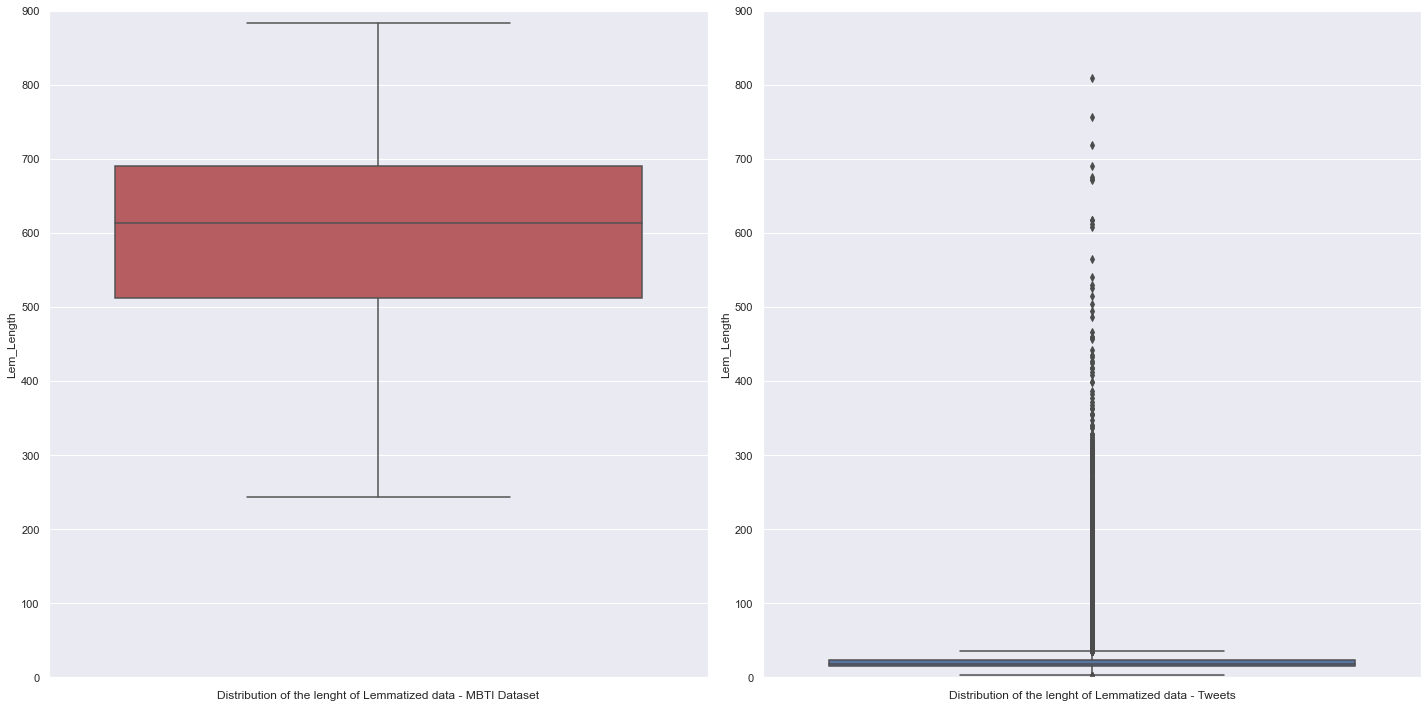

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

mbti_Dataset = pd.read_pickle('mbti_FE.pkl')

mbti_Dataset['Lem_Length'] = mbti_Dataset['Posts_Lemmatized'].apply(lambda x: len(x))
df['Lem_Length'] = df['tweet'].apply(lambda x: len(x))

sns.set(style="darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].set(ylim=(0, 900))
ax[1].set(ylim=(0, 900))

sns.boxplot(data = mbti_Dataset, y='Lem_Length', showfliers=False, ax=ax[0], color = 'r').set(xlabel='Distribution of the lenght of Lemmatized data - MBTI Dataset')
sns.boxplot(data = df, y='Lem_Length', showfliers=True, ax=ax[1], color = 'b').set(xlabel='Distribution of the lenght of Lemmatized data - Tweets')

fig.tight_layout()
plt.show()


# Running prediction

In [ ]:
from sqlalchemy import create_engine
import sqlite3
import joblib
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import pickle


def lemmatizing(text):
    """Lemmatizing the input text using WordNet and NLTK package"""
    NLTK_WNL = nltk.WordNetLemmatizer()
    text_Lem = [NLTK_WNL.lemmatize(word) for word in text]
    return(text_Lem)

tfidf_fit = pickle.load(open("tfidf_all_fit.pkl", "rb"))

fields = ['No_Words-Capital', 'No_WordsInQuotes', 'Avg_WordLength', 'UniqueWrd_vs_NoWrd', 'Sentiment_Score']

df = df.loc[(df.Lem_Length > 20)]#filter tweets base on the lenght of lemmatized

#corpus = tfidf_fit.transform(df['tweet'])
corpus = pd.concat([df[fields].reset_index(drop=True),
              pd.DataFrame(corpus.toarray())], axis = 1)
#corpus = pd.DataFrame(corpus.toarray())
#pickle.dump(corpus, open("corpus.pkl", "wb"))

IE = joblib.load('IE_model.joblib')
NS = joblib.load('NS_model.joblib')
FT = joblib.load('FT_model.joblib')
PJ = joblib.load('PJ_model.joblib')

df['IE'] = IE.predict(corpus)
df['NS'] = NS.predict(corpus)
df['FT'] = FT.predict(corpus)
df['PJ'] = PJ.predict(corpus)


# Map

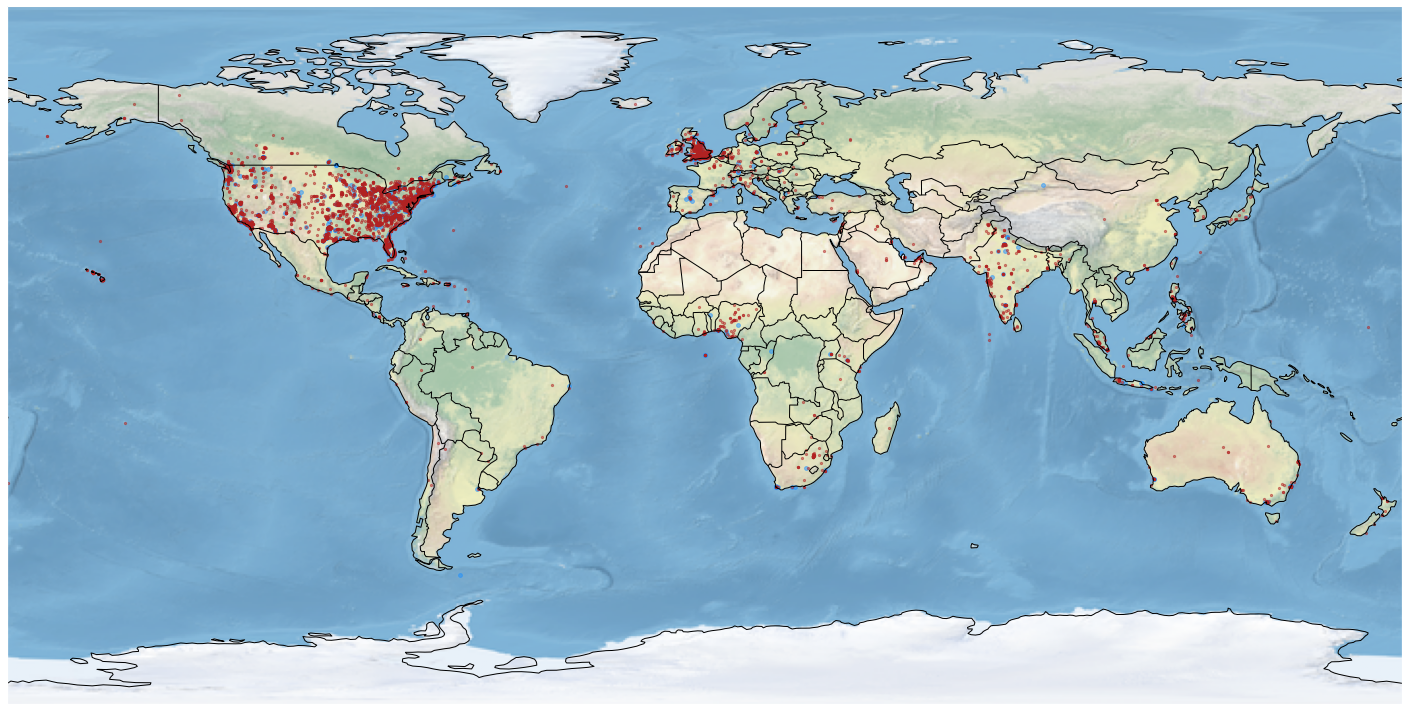

In [101]:
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(25,40))

#ax = fig.add_subplot(1,1,1, projection=crs.Robinson())
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

#ax.set_global()
ax.stock_img()
ax.coastlines()

#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
#ax.gridlines()

df_F = df[df['FT'] == 'F']
df_T = df[df['FT'] == 'T']

plt.scatter(x=df_F.long, y=df_F.lat,
            color="dodgerblue",
            s=15,
            alpha=0.5,
            transform=crs.PlateCarree(), label = 'I')

plt.scatter(x=df_T.long, y=df_T.lat,
            color="firebrick",
            s=5,
            alpha=0.5,
            transform=crs.PlateCarree(), label = 'T')


plt.show()